## Peptide Array Image Analysis Pipeline

### Packages needed

In [1]:
import module as aim

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Image import

In [2]:
# load images
rgb = aim.image_import("images/atg14(aa428-445).png") 

### Image info

In [3]:
aim.image_info(rgb)

Type: <class 'numpy.ndarray'>
Value type: uint8
Dimensions: (369, 309, 3)
Minimum value: 0
Maximum value: 253
Pixels: 342063


### Image Viewing

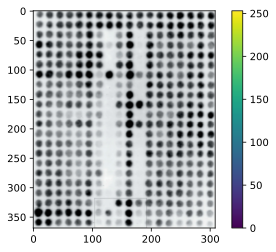

In [4]:
aim.image_view(rgb,"RGB")

### RGB to grayscale (0-255 scale)

In [5]:
gray_byte = aim.rgb2gray(rgb, "byte")
aim.image_info(gray_byte)

Type: <class 'numpy.ndarray'>
Value type: uint8
Dimensions: (369, 309)
Minimum value: 0
Maximum value: 252
Pixels: 114021


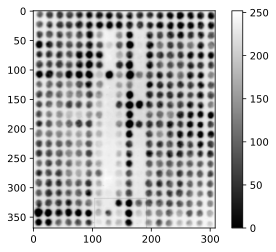

In [6]:
aim.image_view(gray_byte,"Grayscale")

### RGB to grayscale (0-1 scale)

In [7]:
gray_float = aim.rgb2gray(rgb, "float")
aim.image_info(gray_byte)

Type: <class 'numpy.ndarray'>
Value type: uint8
Dimensions: (369, 309)
Minimum value: 0
Maximum value: 252
Pixels: 114021


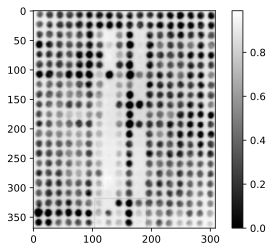

In [8]:
aim.image_view(gray_float,"Grayscale")

### Image Pixel Value Histograms

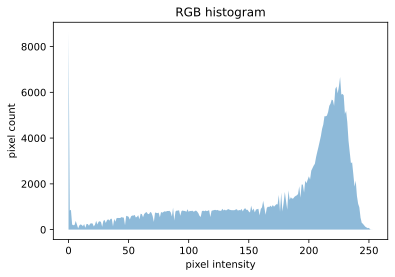

In [9]:
aim.histogram(rgb, "RGB", "byte")

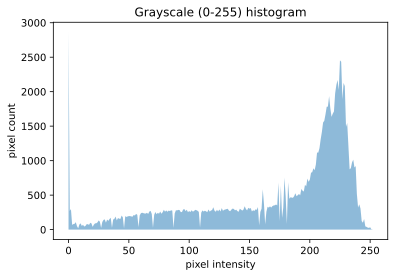

In [10]:
aim.histogram(gray_byte, "Grayscale", "byte")

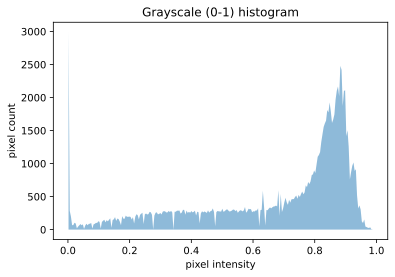

In [11]:
aim.histogram(gray_float, "Grayscale", "float")

### Image Noise Filtering Algorithms (Gaussian/Median)

In [12]:
# sigma (standard deviation) determines the size of the neighborhood
std = np.std(gray_float)

In [13]:
sigma = np.arange(0, 3, 0.5).tolist()

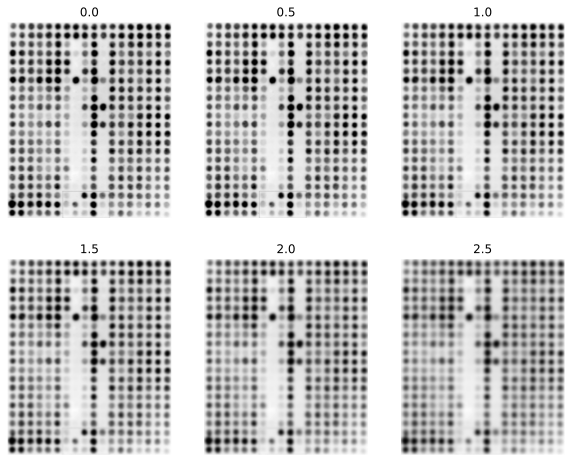

In [14]:
aim.image_filter(gray_float, "Gaussian", parameters=sigma, select=False)

In [15]:
#gauss_filter = aim.image_filter(gray_float, "Gaussian", parameters=sigma, select=True)

In [16]:
disk = np.arange(0, 3, 0.5).tolist()

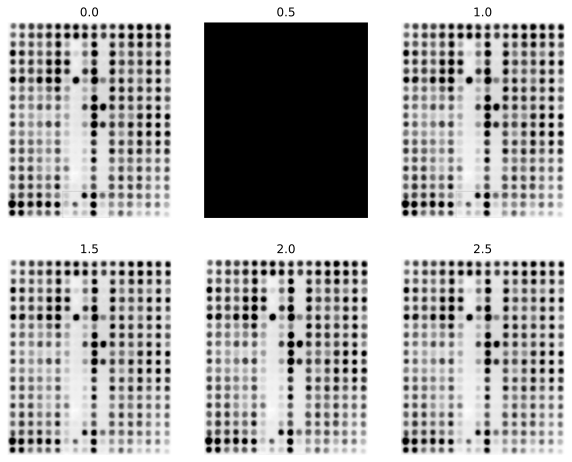

In [17]:
aim.image_filter(gray_float, "median", parameters=disk, select=False)

In [18]:
#median_filter = aim.image_filter(gray_float, "median", parameters=disk, select=True)

### Peptide Array Image Data (Manual Entry)

In [19]:
protein = "ATG14"
peptide_seq = "ETDLGTDWENLPSPRFCD"
start = 428
end = 445
length = end - start + 1
permutation_seq = "ACDEFGHIKLMNPQRSTVWY"
lir_motif = "WENL"
lir_start = 435
lir_end = 438
lir_length = lir_end - lir_start + 1

### Image Segmentation
#### Supervised Algorithms:
1. Active Contour (https://scikit-image.org/docs/dev/api/skimage.segmentation.html?highlight=contour#skimage.segmentation.active_contour)
2. Flood (https://scikit-image.org/docs/dev/api/skimage.segmentation.html?highlight=contour#skimage.segmentation.flood)

#### Active Contour
Active Contour Algorithm is used to validate whether the spot coordinates used are accurate.

In [20]:
width = 18
height = 22
ipd = 17
resolution = 300
center = [6, 10] 
radius = 5
max_px_move = 0.01 # optimal parameter range = 0.01 - 0.05

100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


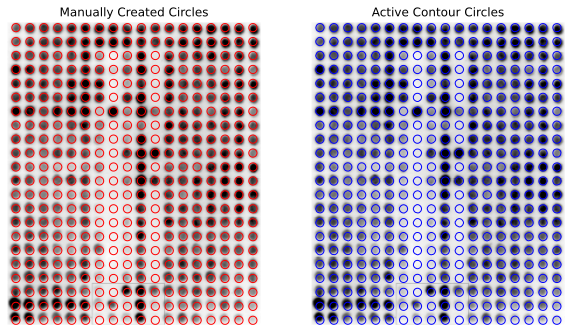

In [21]:
spot_circles_ac, spot_snakes_ac, spot_intensities_ac = aim.segmentation_active_contour(gray_float, width, height, ipd, resolution, center, radius, max_px_move)

As obsreved the initial grid of points given deviates from the best fitting one. This happens in a uniform manner as we move towards the down right corner of the image. Thus to compensate we try to process the image (rotation and/or resize).

In [22]:
scale = (1.01, 1) # skimage.transform.rescale parameter
angle = 0.5 # # skimage.transform.rotation parameter

In [23]:
gray_float_rr = aim.image_processing(gray_float, scale, angle, rescale=True, rotation=True)

In [24]:
width = 18
height = 22
ipd = 17
resolution = 300
center = [6, 10] 
radius = 5
max_px_move = 0.01 # optimal parameter range = 0.01 - 0.05

100%|██████████| 22/22 [00:08<00:00,  2.62it/s]


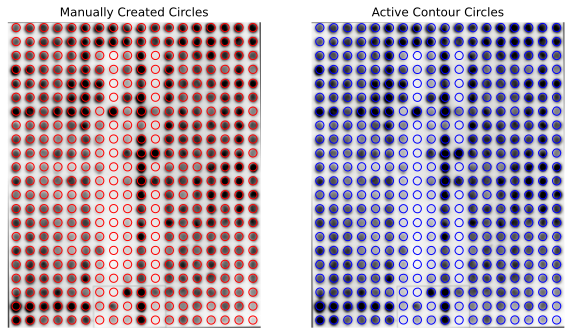

In [25]:
spot_circles_ac_rr, spot_snakes_ac_rr, spot_intensities_ac_rr = aim.segmentation_active_contour(gray_float_rr, width, height, ipd, resolution, center, radius, max_px_move)

#### Flood

Remark: The algorithm performs really good in identifying dark spots. However it performs really poor in the areas of the image where there are no dark pixels.

In [26]:
seed_point = [6,10]
width = 18
height = 22
ipd = 17
tolerance = 0.3
peptide = peptide_seq
permutation = permutation_seq

In [27]:
spot_regions_f, spot_intensities_f = aim.segmentation_flood(gray_float, width, height, seed_point, ipd, tolerance)

100%|██████████| 22/22 [00:00<00:00, 28.65it/s]


### Spot Intensity Tables

The image2table function can provide the spot intensities represented as:
1. mean intensity of pixels representing the area of the spot
2. median intensity of pixels representing the area of the spot
3. mode intensity of pixels representing the area of the spot
4. total intensity of pixels representing the area of the spot

In [28]:
df_mean_ac_rr = aim.image2table(peptide_seq, permutation_seq, spot_intensities_ac_rr, "mean")

In [29]:
df_mean_ac_rr.round(3)

,E,T,D,L,G,T,D,W,E,N,L,P,S,P,R,F,C,D
WT,0.518,0.406,0.359,0.419,0.359,0.312,0.314,0.338,0.449,0.402,0.344,0.357,0.313,0.230,0.147,0.191,0.230,0.178
WT,0.509,0.453,0.362,0.415,0.276,0.287,0.219,0.208,0.281,0.289,0.326,0.309,0.198,0.199,0.132,0.155,0.208,0.172
A,0.435,0.423,0.428,0.543,0.422,0.190,0.686,0.922,0.662,0.212,0.887,0.364,0.396,0.231,0.144,0.268,0.231,0.399
C,0.187,0.299,0.386,0.458,0.431,0.270,0.461,0.829,0.499,0.076,0.853,0.199,0.525,0.340,0.379,0.531,0.253,0.520
D,0.374,0.360,0.354,0.419,0.220,0.144,0.249,0.917,0.704,0.323,0.873,0.211,0.313,0.344,0.281,0.174,0.189,0.173
E,0.403,0.378,0.315,0.455,0.237,0.121,0.350,0.900,0.303,0.105,0.864,0.223,0.453,0.398,0.363,0.293,0.316,0.341
F,0.173,0.134,0.445,0.173,0.158,0.152,0.755,0.114,0.635,0.035,0.546,0.396,0.298,0.357,0.496,0.244,0.234,0.578
G,0.579,0.514,0.476,0.588,0.405,0.302,0.590,0.880,0.717,0.564,0.847,0.198,0.288,0.357,0.261,0.362,0.222,0.414
H,0.447,0.443,0.536,0.585,0.537,0.372,0.644,0.880,0.716,0.096,0.848,0.254,0.306,0.308,0.305,0.416,0.230,0.402
I,0.482,0.499,0.531,0.387,0.469,0.500,0.750,0.888,0.361,0.116,0.076,0.310,0.274,0.397,0.342,0.224,0.342,0.563


### Spot Intensity Table Scaling

The table_scaler function scales the spot intensity values using:
1. StandardScaler() of sklearn module (scaling per column)
2. RobustScaler() of sklearn module (scaling per column)
3. MinMaxScaler() of sklearn module (scaling per column)

In [34]:
normalized_ac_rr = aim.table_scaler(df_mean_ac_rr, "normalization", peptide_seq, permutation_seq)

In [35]:
scaled_table_rr = normalized_ac_rr.round(3)

In [36]:
scaled_table_rr

,E,T,D,L,G,T,D,W,E,N,L,P,S,P,R,F,C,D
WT,0.893,0.613,0.448,0.513,0.378,0.348,0.143,0.270,0.425,0.708,0.323,0.405,0.297,0.149,0.024,0.113,0.186,0.015
WT,0.878,0.695,0.452,0.508,0.263,0.302,0.000,0.113,0.190,0.504,0.301,0.301,0.000,0.068,0.000,0.053,0.150,0.007
A,0.749,0.643,0.580,0.690,0.466,0.125,0.704,0.971,0.721,0.364,0.977,0.419,0.512,0.152,0.019,0.244,0.187,0.338
C,0.315,0.425,0.500,0.569,0.478,0.271,0.365,0.860,0.494,0.119,0.936,0.066,0.843,0.428,0.388,0.687,0.224,0.515
D,0.641,0.532,0.439,0.513,0.185,0.040,0.044,0.965,0.780,0.566,0.960,0.092,0.297,0.438,0.233,0.085,0.118,0.007
E,0.692,0.564,0.363,0.565,0.209,0.000,0.197,0.945,0.221,0.171,0.950,0.117,0.658,0.576,0.362,0.286,0.328,0.253
F,0.291,0.135,0.613,0.165,0.100,0.056,0.808,0.000,0.684,0.045,0.567,0.488,0.259,0.471,0.571,0.203,0.192,0.600
G,1.000,0.803,0.674,0.753,0.442,0.329,0.559,0.921,0.799,1.000,0.929,0.064,0.233,0.470,0.202,0.402,0.173,0.360
H,0.769,0.677,0.789,0.750,0.626,0.456,0.641,0.921,0.796,0.156,0.931,0.183,0.278,0.347,0.270,0.493,0.186,0.343
I,0.830,0.775,0.779,0.468,0.532,0.690,0.801,0.931,0.301,0.192,0.000,0.304,0.197,0.573,0.329,0.170,0.373,0.578


### LIR sequence logo

In [37]:
LIR = df_mean_ac_rr.iloc[2:, 7:11]

In [38]:
LIR

,W,E,N,L
A,0.922074,0.661686,0.211614,0.886752
C,0.828965,0.498776,0.075847,0.852859
D,0.917148,0.704293,0.323105,0.872604
E,0.900181,0.303301,0.104612,0.864198
F,0.113579,0.634886,0.034622,0.546353
G,0.880409,0.717285,0.563544,0.846980
H,0.880393,0.715621,0.096178,0.848065
I,0.888315,0.360724,0.116361,0.075781
K,0.889672,0.819408,0.103272,0.838917
L,0.886210,0.593110,0.009974,0.260897


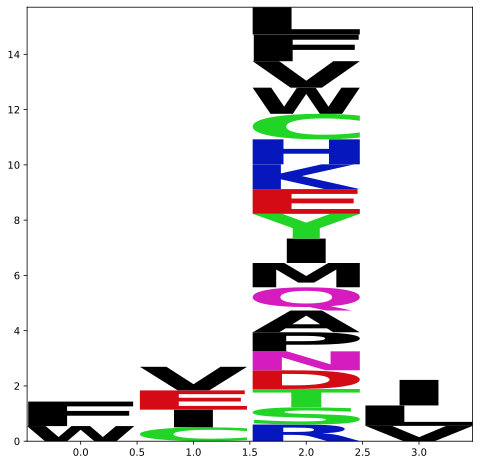

In [52]:
logo = aim.lir_logo(LIR, threshold=0.5, logo=True)

In [48]:
probability_dictionary = aim.lir_logo(LIR, threshold=0.5, logo=False)

W: {'F': 0.886, 'W': 0.546}
E: {'C': 0.501, 'E': 0.697, 'I': 0.639, 'V': 0.855}
N: {'A': 0.788, 'C': 0.924, 'D': 0.677, 'E': 0.895, 'F': 0.965, 'H': 0.904, 'I': 0.884, 'K': 0.897, 'L': 0.99, 'M': 0.88, 'N': 0.686, 'P': 0.69, 'Q': 0.84, 'R': 0.603, 'S': 0.621, 'T': 0.665, 'V': 0.957, 'W': 0.947, 'Y': 0.895}
L: {'I': 0.924, 'L': 0.739, 'V': 0.554}
